# Code to generate Figure 2

In [13]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from utils.svm import LinearSupportVectorMachine_noOffset
from utils.RandFourier import RandomFourier
from utils.functions import * 

import matplotlib
import matplotlib.pyplot as plt

figwidth = 4
figheight = 4

## Generate data

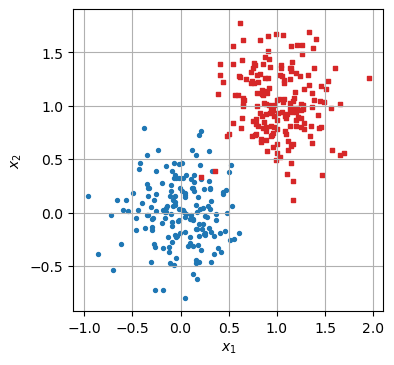

In [14]:
SS = 250
n=2*SS

sigma = .1
mean1 = [1,1]
mean2 = [0,0]

cov1 = [[sigma,0],[0,sigma]]
cov2 = [[sigma,0],[0,sigma]]

s1 = []
s12 = []
s2 = []
s22 = []

import matplotlib.pyplot as plt

np.random.seed(seed=1)
x1, y1 = np.random.multivariate_normal(mean1, cov1, SS).T
x2, y2 = np.random.multivariate_normal(mean2, cov2, SS).T

s1.append([x1,y1])
s2.append([x2,y2])

X = []
Y = []
for i in range(SS):
    X.append([s1[0][0][i], s1[0][1][i]])
    Y.append(-1)
    X.append([s2[0][0][i], s2[0][1][i]])
    Y.append(1)
X=np.array(X)

X_train, X_test, ytrain, ytest = train_test_split(X, Y,test_size=0.3, random_state=40)

y_train = np.asarray(ytrain)
y_test = np.asarray(ytest)

K = np.outer(X_train,X_train)
kappa = np.sqrt(K.max())

# Plot
fig, ax = plt.subplots(figsize=[figwidth, figheight], dpi=100)

ax.scatter(x=X_train[y_train==1,0], y=X_train[y_train==1,1], s=8, c='tab:blue', marker='o')
ax.scatter(x=X_train[y_train==-1,0], y=X_train[y_train==-1,1], s=5, c='tab:red', marker='s')

ax.set(xlabel='', ylabel='', title='')
ax.set(xlabel='$x_1$', ylabel='$x_2$', title='')
ax.grid()

plt.show()

## Find a prototype for each class

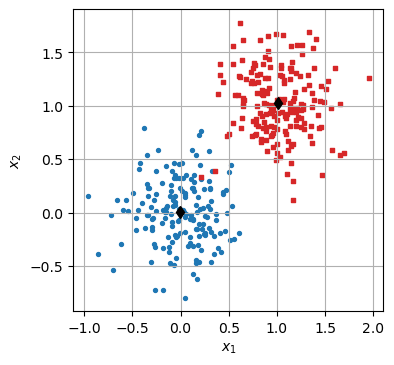

In [15]:
# prototype[0]: class 1
# prototype[1]: class -1

prototype = [np.mean(X_train[y_train == 1], axis=0), np.mean(X_train[y_train == -1], axis=0)]

fig, ax = plt.subplots(figsize=[figwidth, figheight], dpi=100)

ax.scatter(x=X_train[y_train==1,0], y=X_train[y_train==1,1], s=8, c='tab:blue', marker='o')
ax.scatter(x=X_train[y_train==-1,0], y=X_train[y_train==-1,1], s=5, c='tab:red', marker='s')
ax.plot(prototype[0][0], prototype[0][1],'kd')
ax.plot(prototype[1][0], prototype[1][1],'kd')

ax.set(xlabel='', ylabel='', title='')
ax.set(xlabel='$x_1$', ylabel='$x_2$', title='')
ax.grid()

plt.show()


## Train SVM Classifier

In [16]:
C = np.sqrt(n)
X_train_b = add_bias(X_train)
X_test_b = add_bias(X_test)

SVM = LinearSupportVectorMachine_noOffset(C=C)
lagr_multipliers, idx_support_vectors, support_vectors, support_vector_labels = SVM.fit(X_train_b, y_train)

# weight vector
w = np.dot(lagr_multipliers*support_vector_labels,support_vectors)

evaluation = np.sign(SVM.predict(X_test_b).flatten()) == y_test
print("Classification accuracy:", sum(evaluation)/len(evaluation))


Classification accuracy: 0.9866666666666667


In [17]:
F = 2
proba = 0.9
beta = 5

# calculate noise scale: lambda 
noise_lambda = 4*C*kappa*np.sqrt(F+1)/(beta*n)
np.random.seed(seed=10)
mu = np.random.laplace(loc=0.0, scale=noise_lambda, size=(1,F+1))

w_tilde = w + mu.flatten()


In [18]:
x_min, x_max, y_min, y_max = -1,2,-1,2
res = 500j

XX, YY = np.mgrid[x_min:x_max:res, y_min:y_max:res]
X_grid = np.c_[XX.ravel(), YY.ravel()]

X_grid_b = add_bias(X_grid)
Z = SVM.predict(X_grid_b)
Z = Z.reshape(XX.shape)

Z_p = SVM.predict(X_grid_b, mu)
Z_p = Z_p.reshape(XX.shape)

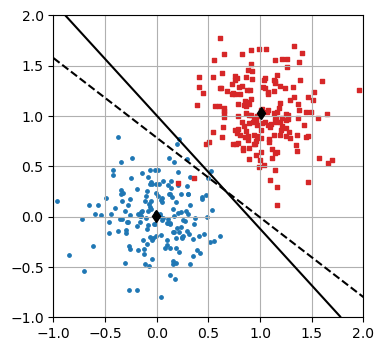

In [19]:
# Plot

fig, ax = plt.subplots(figsize=[figwidth, figheight], dpi=100)

ax.scatter(x=X_train[y_train==1,0], y=X_train[y_train==1,1], s=6, c='tab:blue', marker='o')
ax.scatter(x=X_train[y_train==-1,0], y=X_train[y_train==-1,1], s=6, c='tab:red', marker='s')

plt.contour(XX, YY, Z, colors=['k'], linestyles=['-'], levels=[0])
plt.contour(XX, YY, Z_p, colors=['k'], linestyles=['--'], levels=[0])

ax.plot(prototype[0][0], prototype[0][1],'kd')
ax.plot(prototype[1][0], prototype[1][1],'kd')

ax.set(xlabel='', ylabel='', title='')
ax.grid()

plt.show()

## Select instance and prototype

* Select test data instance whose classification we want to explain 
* Select prototype of opposite class label than that of the selected instance

In [20]:
#np.random.seed(seed=1)
#idx_selected = np.random.randint(0,len(X_test))
idx_selected = 1
instance = [X_test[idx_selected]]
instance_b = [X_test_b[idx_selected]]

prediction_instance = np.sign(SVM.predict(instance_b, noise=0).flatten())
print("Index of selected test data:", idx_selected, "-- Predicted class:", prediction_instance, "-- True class label:", y_test[idx_selected])

# choose prototype of different class than instance
selected_prototype = prototype[np.where(prediction_instance != [1,-1])[0][0]]


Index of selected test data: 1 -- Predicted class: [1.] -- True class label: 1


## Compute explanations

In [21]:
b_robust = prediction_instance*w_tilde / (noise_lambda*np.sqrt(2)*np.log(2*(1-proba)))
b_non_robust = prediction_instance*w_tilde
b_opt = prediction_instance*w

explanation_robust = socp_opt(instance, F, b_robust)
explanation_non_robust = counterfactual_explanation_linear(instance, F, b_non_robust)
explanation_opt = counterfactual_explanation_linear(instance, F, b_opt)


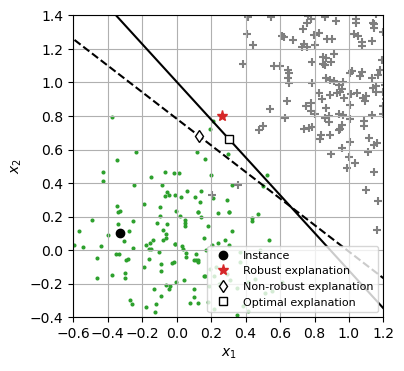

In [22]:
# Plot
fig, ax = plt.subplots(figsize=[figwidth, figwidth], dpi=100)

ax.scatter(x=X_train[y_train==1,0], y=X_train[y_train==1,1], s=15, edgecolors='tab:green', marker=".", facecolors='tab:green')
ax.scatter(x=X_train[y_train==-1,0], y=X_train[y_train==-1,1], s=30, edgecolors='tab:grey', marker='+', facecolors='tab:grey')

plt.contour(XX, YY, Z, colors=['k'], linestyles=['-'], levels=[0], linewidths=1.5)
plt.contour(XX, YY, Z_p, colors=['k'], linestyles=['--'], levels=[0], linewidths=1.5)

ax.plot(instance[0][0],instance[0][1], marker='o', markersize=6, ls="", c='k',mfc="k", label="Instance")
ax.plot(explanation_robust[0],explanation_robust[1],markersize=8, ls="", marker='*', c='tab:red', mfc="tab:red", label="Robust explanation")
ax.plot(explanation_non_robust[0],explanation_non_robust[1], markersize=6, ls="", marker='d', c='k', mfc="w",label="Non-robust explanation")
ax.plot(explanation_opt[0],explanation_opt[1], markersize=6, ls="", marker='s', c='k', mfc="w",label="Optimal explanation")

ax.set(xlabel='$x_1$', ylabel='$x_2$', title='')

ax.grid()
ti = np.arange(-.6,1.3,step=0.2)
ax.set_xticks(ti)
ax.set_xlim(-.6,1.2)
ax.set_ylim(-.4,1.4)
ax.legend(loc='lower right',fontsize=8)
plt.show()